In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam, Optimizer
import keras2.backend as K
import tensorflow as tf
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [35]:
dummy_optimizer = Optimizer()
def q_gradient(state, actor, critic):
    params = actor.trainable_weights
    
    # tensor
    state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    loss = -K.mean(critic_output_tensor)
    gradient_tensor = dummy_optimizer.get_gradients(loss, params)
    
    # calc
    grad_calc_func = K.function([combined_input_tensor[1]], gradient_tensor)
    q_g = grad_calc_func([state]) # ここに0.5sくらいかかる

    return q_g

# Adam クラス
def learning_rate_arr(actor, size=674, u_lr=.00001, tau_lr=.0001):
    grad_idx = 0
    i, j = 0, 0
    lrs = np.zeros((size,))
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            grad_idx += len(w.ravel()) + len(b.ravel())
            if j % 2 == 0: # u
                lrs[i:grad_idx] = u_lr
            else: # tau
                lrs[i:grad_idx] = tau_lr
            i = grad_idx
            j += 1
    return lrs

    
def flatten_gradient(gradient):
    params = []
    for i in range(len(gradient)//2):
        w, b = gradient[2*i], gradient[2*i+1]
        layer_params = np.hstack((w.ravel(), b.ravel()))
        params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params


def get_nn_params(actor):
    params = []
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            layer_params = np.hstack((w.ravel(), b.ravel()))
            params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params

def set_nn_params(actor, params):
    param_idx = 0
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            # set w
            w_prime = params[param_idx:param_idx+w.ravel().shape[0]].reshape(w.shape)
            param_idx += w.ravel().shape[0]

            # set b
            b_prime = params[param_idx:param_idx+b.ravel().shape[0]].reshape(b.shape)
            param_idx += b.ravel().shape[0]

            layer.set_weights([w_prime, b_prime])
    assert params.shape[0] == param_idx
    return actor

class Adam_original():
    def __init__(self, lrs, beta_1=.9, beta_2=.999, epsilon=1e-6):
        self.lrs = lrs # 学習率
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        self.m = np.zeros(674,) # 前回の勾配
        self.v = np.zeros(674,) # 前回の2乗勾配
    
    def update(self, actor, pg):
        # update m
        self.m = (self.beta_1 * self.m) + (1. - self.beta_1) * pg
        
        # update v
        self.v = (self.beta_2 * self.v) + (1. - self.beta_2) * pg**2
        
        # 更新量を決める
        ag = self.lrs * self.m / (np.sqrt(self.v) + self.epsilon)
        
        # 今のパラメータ
        ps = get_nn_params(actor)
        
        # update
        ps = ps - ag
        
        # update
        actor = set_nn_params(actor, ps)
    
        return actor

In [47]:
alpha = 0.4
beta = 1.

# 1ステップのインタラクション
def interaction(state, u, tau, env, ln=0):
    env.reset()
    x = np.array(state)
    env.set_state(x)
    reward = 0
    a_agent, tau = u, tau
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = .01
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    return reward, state1


# 学習データ
def train_data(actor):
    memory = []
    S1 = np.linspace(-7, 7, 20)
    S2 = np.linspace(-7, 7, 20)
    S1, S2 = np.meshgrid(S1, S2)
    S1, S2 = S1.flatten(), S2.flatten()

    for i, x in enumerate(zip(S1, S2)):
        state0 = np.array(x)
        a_agent, tau = actor.predict_on_batch(state0.reshape((1,1,)+state0.shape))[0]
        reward, state1 = interaction(state0, a_agent, tau, env, ln=0.1)
        memory.append([state0, np.array([a_agent, tau]), reward, state1])
    memory = np.array(memory)
    return memory

# Q関数の学習
def td_learning(memory, actor, critic):
    # TODO: loss小さい=関数として正しい　をチェックする
    assert critic.compile, 'compile critic before use this function'
    # critic learning
    epoch = 5000
    batch_size = 32
    arr = np.array(range(memory.shape[0]))
    losses = []
    for _ in range(epoch):
        # make mini_batch
        mem = memory[np.random.choice(arr, batch_size, replace=False)]
        state0_batch = []
        action_batch = []
        reward_batch = []
        state1_batch = []
        for m in mem:
            state0_batch.append([m[0]])
            action_batch.append(m[1])
            reward_batch.append([m[2]])
            state1_batch.append([m[3]])
        state0_batch, action_batch, reward_batch, state1_batch = \
        np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

        # TD error
        next_action = actor.predict_on_batch(state1_batch)
        state1_batch_with_action = [next_action, state1_batch]
        target = critic.predict_on_batch(state1_batch_with_action)
        discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
        r_second = np.multiply(discount, target)
        r = reward_batch + r_second

        # learn
        critic_input_batch = [action_batch, state0_batch]
        loss = critic.train_on_batch(critic_input_batch, r)
        
        losses.append(loss)
        
    return critic, losses

# 勾配の計算
def policy_gradient(actor, critic, init_state = np.array([1,2])):
    # 初期状態からのシミュレーション
    x = init_state
    episode_time = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env)
        episode_time += tau
        if episode_time >= 10.:
            log.append([x, episode_time])
            break
    
    pg = 0
    # Q 関数の勾配を計算する
    for x, t in log:
        g = q_gradient([x], actor, critic)
        g = flatten_gradient(g)
        g *= np.exp(- alpha * t)
        pg += g
    return pg

# 評価
def evaluation(actor, init_state = np.array([1,2])):
    x = init_state
    episode_time = 0
    episode_reward = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.1)
        episode_reward += np.exp(- alpha * episode_time) * reward
        episode_time += tau
        if episode_time >= 10.:
            log.append([x, episode_time])
            break
    return episode_reward


In [48]:
actor = branch_actor((2,),(2,))
critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')

In [50]:
# actor.load_weights('../saved_agent/linear_init_extend_actor.h5')
actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
critic.load_weights('../saved_agent/learned_self_linear1_extend_critic_l.h5')
lrs = learning_rate_arr(actor, size=674, u_lr=.0001, tau_lr=.001)
opt = Adam_original(lrs)
ev = evaluation(actor)
print(f'value_function for initial policy = {ev}')
for i in range(100):
    d_train = train_data(actor)
    critic, losses = td_learning(d_train, actor, critic)
    pg = policy_gradient(actor, critic)
    actor = opt.update(actor, pg/np.linalg.norm(pg))
    ev = evaluation(actor)
    print(f'{i+1}-step')
    print(f'loss of critic is {np.mean(losses)}, value_fuction V(s) = {ev}')
    print(f'|g| = {np.linalg.norm(pg)}')

value_function for initial policy = -3.9255918575627646
1-step
loss of critic is 0.03621330112218857, value_fuction V(s) = -4.018808799435524
|g| = 50.82610183003661
2-step
loss of critic is 0.03373697027564049, value_fuction V(s) = -4.64351215701202
|g| = 79.01196990387226
3-step
loss of critic is 0.07022620737552643, value_fuction V(s) = -4.348116571621426
|g| = 135.8510401742245
4-step
loss of critic is 0.18855665624141693, value_fuction V(s) = -4.339481263437224
|g| = 60.05983259220847
5-step
loss of critic is 0.1342809498310089, value_fuction V(s) = -4.0939914022254404
|g| = 194.10719376960728
6-step
loss of critic is 0.289732962846756, value_fuction V(s) = -3.583970104720851
|g| = 233.97171955567094
7-step
loss of critic is 0.4031905233860016, value_fuction V(s) = -3.2789341810720694
|g| = 671.8740695926691
8-step
loss of critic is 0.3127531111240387, value_fuction V(s) = -2.961033189808928
|g| = 463.8386505486711
9-step
loss of critic is 0.32481521368026733, value_fuction V(s) =

KeyboardInterrupt: 

In [74]:
env.reset()
# actor.load_weights('../saved_agent/learned_self_linear_ideal0_actor.h5')
# actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
initial_state = np.array([1., 2.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    taus.append(tau)
    tau = np.clip(tau, .01, 10.)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=0.1)
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(actor.predict_on_batch(env.state.reshape(1,1,2))[0][0])
states = np.array(states)
detail_states = np.array(detail_states)

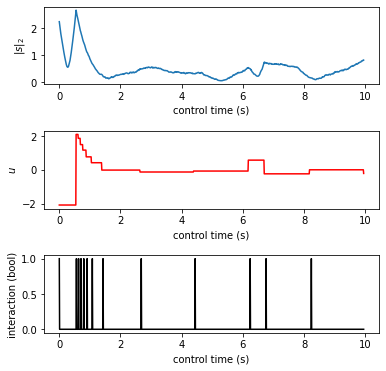

In [75]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [76]:
actor.save_weights('../saved_agent/learned_self_linear_ideal1_actor.h5')
critic.save_weights('../saved_agent/learned_self_linear_ideal1_critic.h5')

In [122]:
actor.load_weights('../saved_agent/learned_self_linear_ideal0_actor.h5')
actor.layers[2].get_weights()[0][0]

array([ 0.41994604,  0.4266636 , -0.18461692,  0.16705216, -0.25361168,
        0.34438944,  0.10308936, -0.09404683, -0.1733037 , -0.22091635,
       -0.3533952 ,  0.02600434,  0.5435894 , -0.07042186, -0.3707666 ,
        0.3166266 ], dtype=float32)

In [121]:
actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
actor.layers[2].get_weights()[0][0]

array([ 0.42221597,  0.4274628 , -0.18825793,  0.16885139, -0.2542188 ,
        0.34214336,  0.10563881, -0.09488146, -0.17566861, -0.22360145,
       -0.3501546 ,  0.02824089,  0.54246134, -0.07161091, -0.37361035,
        0.31443065], dtype=float32)

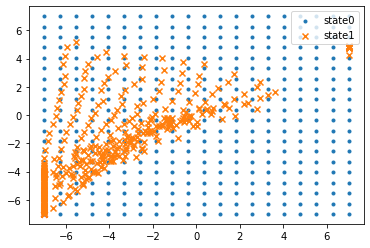

In [39]:
memory = d_train
action_memory = np.array(memory[:,1].tolist())
state0_memory = np.array(memory[:,0].tolist())
state1_memory = np.array(memory[:,3].tolist())
plt.scatter(state0_memory[:,0], state0_memory[:,1], marker='.', label='state0')
plt.scatter(state1_memory[:,0], state1_memory[:,1], marker='x', label='state1')
plt.legend()
plt.show()

In [40]:
alpha = 0.4
beta = 1.

# Q関数の学習
def td_learning(memory, actor, critic):
    # TODO: loss小さい=関数として正しい　をチェックする
    assert critic.compile, 'compile critic before use this function'
    # critic learning
    epoch = 1000
    batch_size = 32
    arr = np.array(range(memory.shape[0]))
    losses = []
    for _ in range(epoch):
        # make mini_batch
        mem = memory[np.random.choice(arr, batch_size, replace=False)]
        state0_batch = []
        action_batch = []
        reward_batch = []
        state1_batch = []
        for m in mem:
            state0_batch.append([m[0]])
            action_batch.append(m[1])
            reward_batch.append([m[2]])
            state1_batch.append([m[3]])
        state0_batch, action_batch, reward_batch, state1_batch = \
        np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

        # TD error
        next_action = actor.predict_on_batch(state1_batch)
        state1_batch_with_action = [next_action, state1_batch]
        target = critic.predict_on_batch(state1_batch_with_action)
        discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
        r_second = np.multiply(discount, target)
        r = reward_batch + r_second

        # learn
        critic_input_batch = [action_batch, state0_batch]
        loss = critic.train_on_batch(critic_input_batch, r)
        
        losses.append(loss)
    return critic, losses

In [41]:
critic.compile(Adam(lr=0.0001, clipnorm=1.), loss='mean_squared_error')
_, losses = td_learning(d_train, actor, critic)

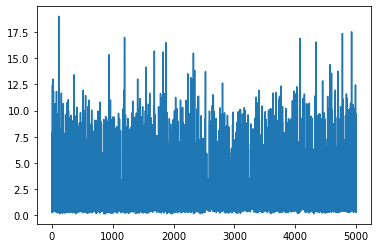

In [51]:
plt.plot(losses)

In [ ]:
get_weights()

In [52]:
%%time
S1 = np.linspace(-7, 7, 20)
S2 = np.linspace(-7, 7, 20)
S1, S2 = np.meshgrid(S1, S2)
S1, S2 = S1.flatten(), S2.flatten()

vts, vps = [], []

for i, x in enumerate(zip(S1, S2)):
    state = np.array(x)
    #vts.append(value_function(state, actor, env, step_limit=200, n_episodes=1, ln=0)[0])
    action = actor.predict_on_batch(state.reshape(1,1,2))[0]
    vps.append(critic.predict_on_batch([action.reshape(1,2), state.reshape(1,1,2)])[0][0])
    print('\r' + f'{int(i*100/len(S1))} %', end='')

#vts = np.array(vts) # linear_vts_learned.csv
vps = np.array(vps) # linear_vps_learned.csv

99 %CPU times: user 813 ms, sys: 135 ms, total: 948 ms
Wall time: 950 ms


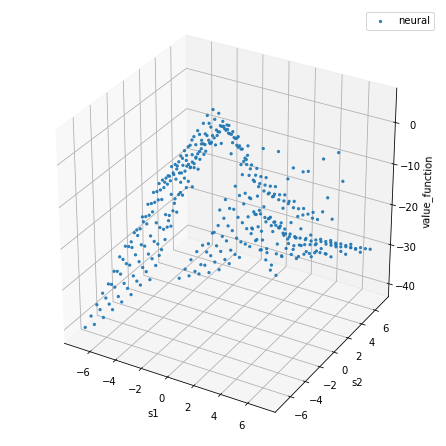

In [53]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('value_function')

#ax.scatter3D(S1.reshape(20,20), S2.reshape(20,20), vts, marker='.', alpha=0.9, label='simulation')
ax.scatter3D(S1.reshape(20,20), S2.reshape(20,20), vps, marker='.', alpha=0.9, label='neural')
plt.legend()